#### NLP course project

In [1]:
import pandas as pd
import nltk as nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import math
from textblob import TextBlob
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from collections import Counter
import itertools

###### Reading the data

In [2]:
data = pd.read_pickle('/project/msca/kadochnikov/news/news_chicago_il.pkl')

In [3]:
data.shape

(28604, 4)

In [4]:
data.head()

,crawled,language,text,title
0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round ...",Family affair: Bears fourth-round WR Riley Rid...
1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Cont...,Coin Flip Determines Winner Of Election In Chi...
2,2019-04-27T23:28:26.072+03:00,english,Fill in your details below or click an icon to...,FOX NEWS: Late April storm dumps snow across M...
3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/T...,Chicago Police Department ‘Fixes’ Their FOID R...
4,2019-04-27T23:30:02.083+03:00,english,Comment If the Chicago Bulls are willing to ge...,Chicago Bulls: 76ers Tobias Harris free agency...


In [5]:
pd.set_option('display.max_colwidth', 100)

###### Loading stopwords, punctuation, lemmatizer

In [6]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [7]:
def lemmatizer(text):
    
    cleaned_text = []
    
    for word in text.split():
        if word in stop:
            continue
        
        word = word.lower()
        
        if word in ['il', 'ill.']:
            word = 'illinois'
        
        word =  ''.join([ char for char in word if char not in exclude])
        
        word = lemma.lemmatize(word)
        
        if len(word) == 0:
            #Ignore whitespace
            continue
        
        cleaned_text.append(word)
    return cleaned_text

###### Creating 2 new columns which we will use to perform exploratory analysis and data cleaning

In [8]:
data['cleaned_text_list'] = data.text.apply(lemmatizer)
data['cleaned_text'] = data.cleaned_text_list.apply(lambda x: ' '.join(x))

In [9]:
data.head()

,crawled,language,text,title,cleaned_text_list,cleaned_text
0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round 4 at No. 126 overall, the Bears selected Georgia W...",Family affair: Bears fourth-round WR Riley Ridley feeling the love from Chicago,"[with, second, pick, draft, round, 4, no, 126, overall, bear, selected, georgia, wr, riley, ridl...",with second pick draft round 4 no 126 overall bear selected georgia wr riley ridley little broth...
1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Contact Reporter Ted Slowik: A toss of an 1899 silver ...,Coin Flip Determines Winner Of Election In Chicago Suburb,"[from, article, chicago, tribune, contact, reporter, ted, slowik, a, toss, 1899, silver, dollar,...",from article chicago tribune contact reporter ted slowik a toss 1899 silver dollar decided tie t...
2,2019-04-27T23:28:26.072+03:00,english,Fill in your details below or click an icon to log in: Email (required) (Address never made publ...,"FOX NEWS: Late April storm dumps snow across Midwestern states, Chicago faces up to 8 inches","[fill, detail, click, icon, log, in, email, required, address, never, made, public, name, requir...",fill detail click icon log in email required address never made public name required you comment...
3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/Teresa Crawford)\nJust in time to have the entire F...,Chicago Police Department ‘Fixes’ Their FOID Reporting Problems,"[chicago, police, supt, eddie, johnson, ap, phototeresa, crawford, just, time, entire, foid, car...",chicago police supt eddie johnson ap phototeresa crawford just time entire foid card system void...
4,2019-04-27T23:30:02.083+03:00,english,"Comment If the Chicago Bulls are willing to get creative in free agency, the versatile and effic...",Chicago Bulls: 76ers Tobias Harris free agency target merited,"[comment, if, chicago, bull, willing, get, creative, free, agency, versatile, efficient, tobias,...",comment if chicago bull willing get creative free agency versatile efficient tobias harris could...


###### Checking commmonly used words in the corpus

In [10]:
words = list(itertools.chain.from_iterable(data.cleaned_text_list.tolist()))
c = Counter(words)
c.most_common()

[('the', 75507),
 ('chicago', 68269),
 ('illinois', 46626),
 ('said', 34305),
 ('i', 29413),
 ('may', 27592),
 ('2019', 22335),
 ('year', 21365),
 ('work', 20472),
 ('one', 20201),
 ('a', 18626),
 ('state', 17946),
 ('new', 17196),
 ('time', 16963),
 ('also', 16722),
 ('share', 16204),
 ('day', 15881),
 ('in', 15575),
 ('it', 15519),
 ('company', 15356),
 ('first', 14370),
 ('would', 14157),
 ('service', 13757),
 ('get', 13569),
 ('this', 13070),
 ('two', 13034),
 ('police', 12882),
 ('last', 12499),
 ('city', 12406),
 ('people', 12295),
 ('job', 12010),
 ('home', 11874),
 ('u', 11257),
 ('team', 11171),
 ('say', 10927),
 ('—', 10711),
 ('tool', 10590),
 ('–', 10557),
 ('like', 10404),
 ('stock', 9695),
 ('school', 9632),
 ('business', 9578),
 ('he', 9567),
 ('make', 9477),
 ('report', 9429),
 ('1', 9341),
 ('news', 9314),
 ('game', 9281),
 ('we', 9257),
 ('experience', 9081),
 ('need', 8821),
 ('product', 8324),
 ('pm', 8289),
 ('you', 7989),
 ('family', 7985),
 ('community', 7924),
 

###### Performing Topic modelling using LDA to see what topics we have in the data (based on exploratory analysis, 9 seems to be optimal number of topics)

In [11]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data.cleaned_text_list.tolist())

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(article) for article in data.cleaned_text_list.tolist()]

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=9, id2word = dictionary, passes=50) 


CPU times: user 5min 33s, sys: 57.3 s, total: 6min 31s
Wall time: 6min 2s


In [12]:
for topic_number, topic in ldamodel.print_topics():
    print(topic)
    print('---------------------------------------------------------------------------------')

0.019*"illinois" + 0.013*"state" + 0.012*"the" + 0.010*"tax" + 0.009*"would" + 0.007*"said" + 0.006*"may" + 0.005*"bill" + 0.005*"year" + 0.004*"new"
---------------------------------------------------------------------------------
0.020*"said" + 0.016*"the" + 0.012*"chicago" + 0.010*"baby" + 0.008*"explosion" + 0.008*"police" + 0.008*"fire" + 0.008*"illinois" + 0.007*"body" + 0.006*"may"
---------------------------------------------------------------------------------
0.019*"i" + 0.011*"chicago" + 0.010*"the" + 0.006*"one" + 0.005*"get" + 0.005*"it" + 0.005*"like" + 0.004*"time" + 0.004*"year" + 0.004*"a"
---------------------------------------------------------------------------------
0.025*"day" + 0.010*"chicago" + 0.009*"date" + 0.007*"2019" + 0.006*"number" + 0.006*"deth" + 0.005*"uf" + 0.005*"birthdate" + 0.005*"zoo" + 0.005*"april"
---------------------------------------------------------------------------------
0.030*"share" + 0.022*"illinois" + 0.021*"stock" + 0.021*"tool" + 0

###### Removing articles containing the words 'figueroa' , 'ochoalopez', and 'clarisa' as these articles related to a ongoing investigation and is not in-scope for this project. Also removing articles containing the word explosion as the articles are related to either a plant fire or american airline accident and not related to the scope of this project

In [13]:
data = data[data.cleaned_text_list.apply(lambda x: False if set(x).intersection(set(['figueroa', 'ochoalopez', 'clarisa', 'explosion'])) else True)]

###### Removing duplicate articles

In [14]:
data.shape

(27035, 6)

In [15]:
data = data.drop_duplicates(subset='text', keep="last")

In [16]:
data.shape

(24601, 6)

###### Applying LDA again to identify topics (based on exploratory analysis 4 seem to be optimal number of topics)

In [17]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data.cleaned_text_list.tolist())

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(article) for article in data.cleaned_text_list.tolist()]

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=4, id2word = dictionary, passes=50) 

CPU times: user 4min 49s, sys: 1min 2s, total: 5min 52s
Wall time: 5min 22s


In [18]:
for topic_number, topic in ldamodel.print_topics():
    print(topic)
    print('---------------------------------------------------------------------------------')

0.013*"illinois" + 0.011*"the" + 0.010*"work" + 0.009*"share" + 0.008*"company" + 0.006*"tool" + 0.006*"job" + 0.006*"stock" + 0.005*"service" + 0.005*"rating"
---------------------------------------------------------------------------------
0.012*"i" + 0.010*"chicago" + 0.009*"the" + 0.006*"said" + 0.005*"one" + 0.004*"it" + 0.004*"get" + 0.004*"would" + 0.004*"time" + 0.004*"like"
---------------------------------------------------------------------------------
0.015*"chicago" + 0.012*"the" + 0.008*"may" + 0.008*"2019" + 0.007*"police" + 0.006*"said" + 0.006*"illinois" + 0.006*"day" + 0.004*"city" + 0.004*"pm"
---------------------------------------------------------------------------------
0.016*"chicago" + 0.013*"the" + 0.008*"game" + 0.008*"illinois" + 0.005*"team" + 0.005*"2019" + 0.005*"may" + 0.005*"cub" + 0.005*"season" + 0.004*"run"
---------------------------------------------------------------------------------


###### Saving the data so that we can come back to it again

In [19]:
data.to_csv('nlp_project_df_cleansed.csv')

###### Assigning topic number to each article

In [20]:
data['topic_number'] = [ldamodel.get_document_topics(doc)[0][0] for doc in doc_term_matrix]

In [21]:
data.head()

,crawled,language,text,title,cleaned_text_list,cleaned_text,topic_number
0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round 4 at No. 126 overall, the Bears selected Georgia W...",Family affair: Bears fourth-round WR Riley Ridley feeling the love from Chicago,"[with, second, pick, draft, round, 4, no, 126, overall, bear, selected, georgia, wr, riley, ridl...",with second pick draft round 4 no 126 overall bear selected georgia wr riley ridley little broth...,3
1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Contact Reporter Ted Slowik: A toss of an 1899 silver ...,Coin Flip Determines Winner Of Election In Chicago Suburb,"[from, article, chicago, tribune, contact, reporter, ted, slowik, a, toss, 1899, silver, dollar,...",from article chicago tribune contact reporter ted slowik a toss 1899 silver dollar decided tie t...,1
3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/Teresa Crawford)\nJust in time to have the entire F...,Chicago Police Department ‘Fixes’ Their FOID Reporting Problems,"[chicago, police, supt, eddie, johnson, ap, phototeresa, crawford, just, time, entire, foid, car...",chicago police supt eddie johnson ap phototeresa crawford just time entire foid card system void...,0
4,2019-04-27T23:30:02.083+03:00,english,"Comment If the Chicago Bulls are willing to get creative in free agency, the versatile and effic...",Chicago Bulls: 76ers Tobias Harris free agency target merited,"[comment, if, chicago, bull, willing, get, creative, free, agency, versatile, efficient, tobias,...",comment if chicago bull willing get creative free agency versatile efficient tobias harris could...,0
5,2019-04-27T23:30:10.002+03:00,english,Comment The 2018-19 season was the most important season of Chicago Bulls guard Zach LaVine’s yo...,Chicago Bulls: Grading Zach LaVine’s 2018-19 season,"[comment, the, 201819, season, important, season, chicago, bull, guard, zach, lavine’s, young, c...",comment the 201819 season important season chicago bull guard zach lavine’s young career here’s ...,1


###### Creating word cloud of each topic (based on topic number) to identify key words

In [5]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

######  - Topic 0

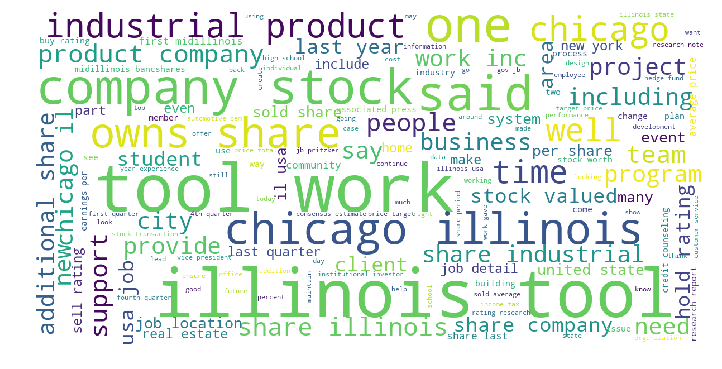

In [23]:
show_wordcloud(','.join(data[data.topic_number == 0].cleaned_text.tolist()))

###### - Topic 1

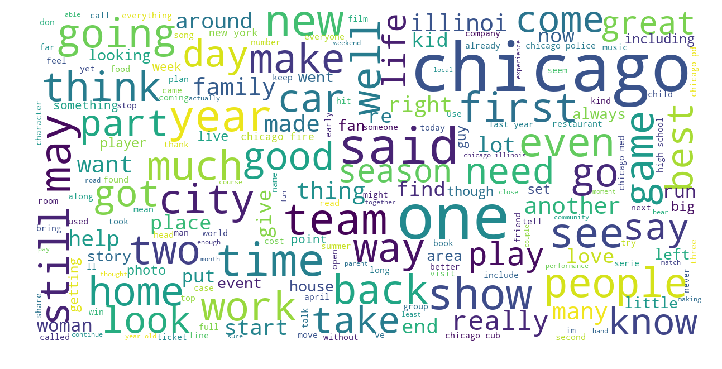

In [24]:
show_wordcloud(','.join(data[data.topic_number == 1].cleaned_text.tolist()))

###### - Topic 2

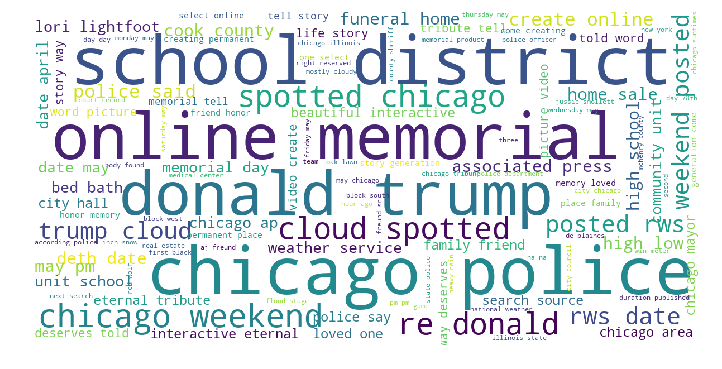

In [25]:
show_wordcloud(','.join(data[data.topic_number == 2].cleaned_text.tolist()))

###### - Topic 3

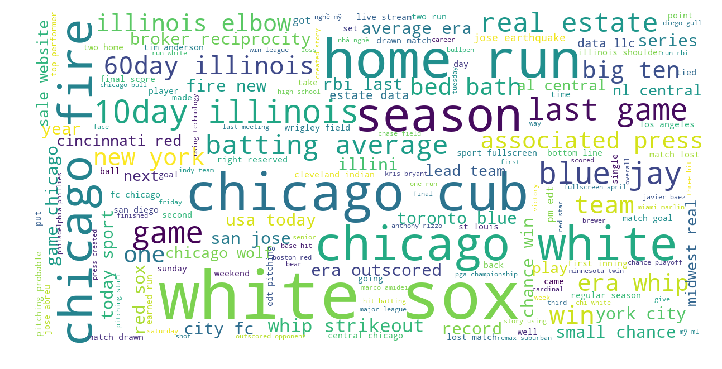

In [26]:
show_wordcloud(','.join(data[data.topic_number == 3].cleaned_text.tolist()))

Based on the above word clouds, we observe the following
 - Topic 0: It is mainly about what press has been saying. Most of the articles seem to involve Chicago Police
 - Topic 1: Articles are mainly about Cubs and Sox
 - Topic 2: Articles are mainly about work, companies, stocks
 - Topic 3: Articles seem to be about the job market in Chicago and what the job requirements are.

###### Let's look at the word cloud of titles to see if we get some additional information

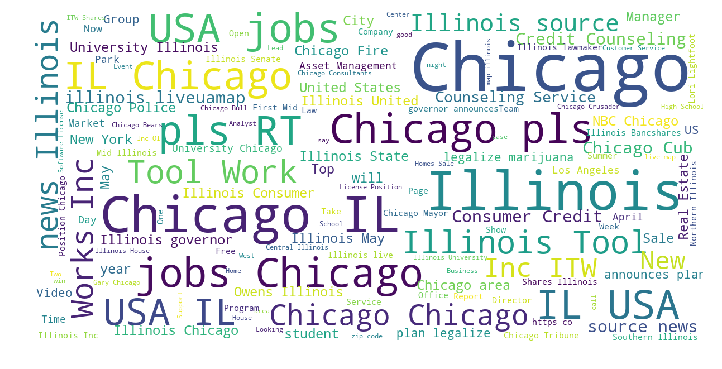

In [27]:
show_wordcloud(','.join(data[data.topic_number == 0].title.tolist()))

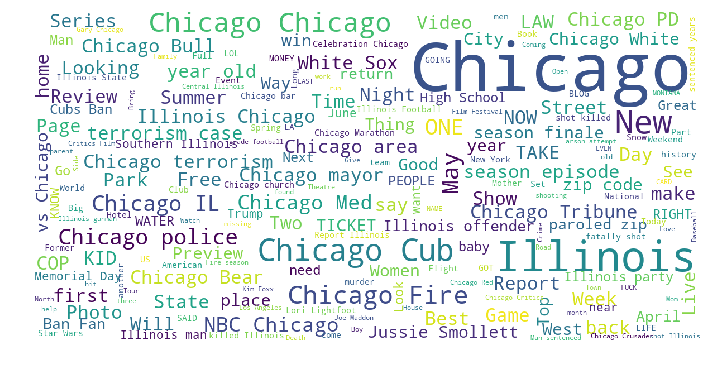

In [28]:
show_wordcloud(','.join(data[data.topic_number == 1].title.tolist()))

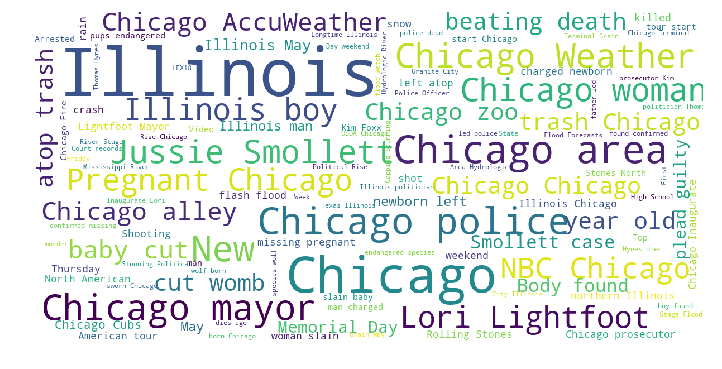

In [29]:
show_wordcloud(','.join(data[data.topic_number == 2].title.tolist()))

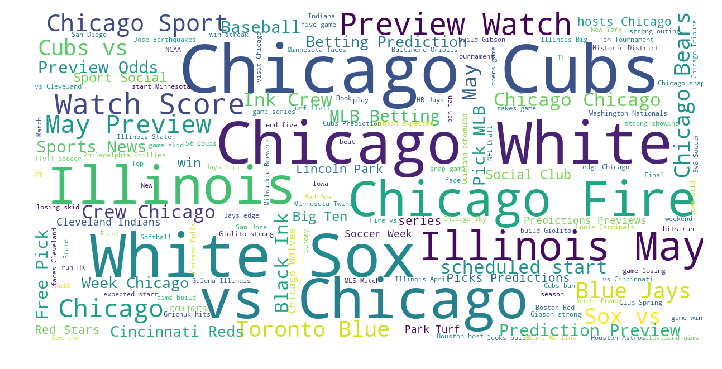

In [30]:
show_wordcloud(','.join(data[data.topic_number == 3].title.tolist()))

Based on the above word clouds, we see same observations as the text word clouds. We see following four themes in our data
 - Topic 0: News related to Government agencies, such as Chicago PD, Government legalizing Marijuana, Mayor Elections
 - Topic 1: Sports and Entertainment
 - Topic 2: Different types of firms/industries in the state
 - Topic 3: Jobs

###### Let's determine the sentiment by creating dictionary of keywords

In [31]:
data[data.topic_number == 0].title

3                                            Chicago Police Department ‘Fixes’ Their FOID Reporting Problems
4                                              Chicago Bulls: 76ers Tobias Harris free agency target merited
8                                                               A Tale of Two Contracts: KC vs Chicago Wheat
9                                        Striking Chicago musicians approve 5-year contract | MarketBeat.com
11                                                  Illinois Tool Works (ITW) Price Target Raised to $165.00
15                                                          Chicago Faucet Foot Control 625 (so.cen.il.) $85
16                           2005 ford f550 super duty flat bed 4x4 diesel (Fairview Heights Illinois) $5700
17                                          Chicago Electric 36 amp air plasma cutter (Ladera and 72nd) $100
18                                   Snowing in Chicago on April 27th. Sure we all believe you, northerners.
19                 

In [32]:
data[data.topic_number == 1].title

1                                                  Coin Flip Determines Winner Of Election In Chicago Suburb
5                                                        Chicago Bulls: Grading Zach LaVine’s 2018-19 season
6                        Vintage 1983 ANNCO Chicago White Sox A. L West Champs Snapback Hat HTF (Gurnee) $60
14                                       Snow in Chicago at this time is weird, but we're getting numb to it
27                             FREE ASSORTED FURNITURE FOR PICKUP ONLY (10 E Ontario St, Chicago, IL 606011)
34                                                              2019 Chicago Summer Whiskey Tasting Festival
37                        Late April storm dumps snow across Midwestern states, Chicago faces up to 8 inches
40                                                               Tigers-White Sox game in Chicago snowed out
46                                                            Wood barn stall doors (Southern illinois) $100
62                 

In [33]:
data[data.topic_number == 2].title

7                                                 Tigers-White Sox game in Chicago postponed because of snow
31                                       2019 NFL draft: Chiefs select Illinois C Nick Allegretti in Round 7
33                                                    Chicago airport cancels over 500 flights as snow falls
47                                            Chicago Weather: Winter Storm Warning issued for city, suburbs
55                                                               Harriet Marie Waddy, 90, Waterloo, Illinois
56                                                                    Penny Taylor, 62, Belleville, Illinois
58                                                                   John H. Bauer, 96, Evansville, Illinois
59                                                                Carol J. Herndon, 80, Belleville, Illinois
60                                                                 Glenn Pizzini, 88, Edwardsville, Illinois
66                 

In [34]:
data[data.topic_number == 3].title

0                            Family affair: Bears fourth-round WR Riley Ridley feeling the love from Chicago
12               Steelers Select Northern Illinois OLB Sutton Smith In The Sixth-Round Of The 2019 NFL Draft
20       #P.D.F. FREE DOWNLOAD^ The Age of French Impressionism Masterpieces from the Art Institute of Ch...
50                                                 Montreal Impact vs. Chicago Fire | 2019 MLS Match Preview
52                           Family affair: Bears fourth-round WR Riley Ridley feeling the love from Chicago
76                               Chicago Bears draft Kansas State cornerback Duke Shelley in the sixth round
77                                    Chicago Bears draft Riley Ridley in fourth-round of the 2019 NFL Draft
85                      Julian Love, Dexter Williams Among Notre Dame Stars Taken in NFL Draft - NBC Chicago
101                     Chicago Bears select K-State defensive back Duke Shelley in sixth round of NFL Draft
110      The good, 

###### Based on the above titles, we can create sentiment dictionary as shown below

In [35]:
negative = [
    'postponed',
    'strike',
    'striking',
    'snow',
    'weird',
    'snowing',
    'cancels',
    'storm',
    'killed',
    'bullet',
    'snowed',
    'storm',
    'gun',
    'guns',
    'violent',
    'violence',
    'thunderstorms',
    'tornado',
    'warning',
    'flood',
    'bad',
    'ugly',
    'counterfeit',
    'falls',
]

In [36]:
positive = [
    'approve',
    'winner',
    'fixes',
    'legalize',
    'delight',
    'bulls',
    'bears',
    'love',
    'free',
    'festival',
    'good',
    'deal',
    'bars',
    'musical',
    'raised',
    'upgraded',
    'hiring',
    'job',
    'jobs',
]

###### Performing sentiment analysis on cleaned text

In [37]:
def sentiment(text):
    score = 0
    words = text.split()
    if words:
        for word in words:
            if word in negative:
                score = score - 1
            if word in positive:
                score = score + 1
        sentiment_score = score/len(words)

        if sentiment_score < 0:
            return 'negative'
        if sentiment_score > 0:
            return 'positive'
    return 'neutral'

In [38]:
data['sentiment'] = data.cleaned_text.apply(sentiment)

In [39]:
data.head()

,crawled,language,text,title,cleaned_text_list,cleaned_text,topic_number,sentiment
0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round 4 at No. 126 overall, the Bears selected Georgia W...",Family affair: Bears fourth-round WR Riley Ridley feeling the love from Chicago,"[with, second, pick, draft, round, 4, no, 126, overall, bear, selected, georgia, wr, riley, ridl...",with second pick draft round 4 no 126 overall bear selected georgia wr riley ridley little broth...,3,neutral
1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Contact Reporter Ted Slowik: A toss of an 1899 silver ...,Coin Flip Determines Winner Of Election In Chicago Suburb,"[from, article, chicago, tribune, contact, reporter, ted, slowik, a, toss, 1899, silver, dollar,...",from article chicago tribune contact reporter ted slowik a toss 1899 silver dollar decided tie t...,1,neutral
3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/Teresa Crawford)\nJust in time to have the entire F...,Chicago Police Department ‘Fixes’ Their FOID Reporting Problems,"[chicago, police, supt, eddie, johnson, ap, phototeresa, crawford, just, time, entire, foid, car...",chicago police supt eddie johnson ap phototeresa crawford just time entire foid card system void...,0,negative
4,2019-04-27T23:30:02.083+03:00,english,"Comment If the Chicago Bulls are willing to get creative in free agency, the versatile and effic...",Chicago Bulls: 76ers Tobias Harris free agency target merited,"[comment, if, chicago, bull, willing, get, creative, free, agency, versatile, efficient, tobias,...",comment if chicago bull willing get creative free agency versatile efficient tobias harris could...,0,positive
5,2019-04-27T23:30:10.002+03:00,english,Comment The 2018-19 season was the most important season of Chicago Bulls guard Zach LaVine’s yo...,Chicago Bulls: Grading Zach LaVine’s 2018-19 season,"[comment, the, 201819, season, important, season, chicago, bull, guard, zach, lavine’s, young, c...",comment the 201819 season important season chicago bull guard zach lavine’s young career here’s ...,1,positive


###### Plotting Sentiment (in order to avoid unconcious bias while determining sentiment, only the words seen in exploratory analysis were used to create the sentiment keywords. Adding keywords such as Crime, drugs, investment would have changed the sentiment significantly, however that would not have been the right thing to do)

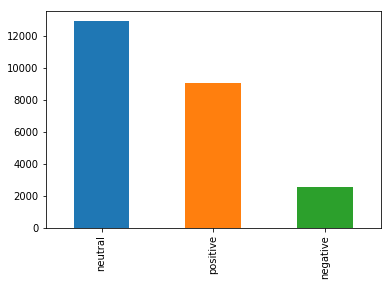

In [40]:
pd.value_counts(data['sentiment']).plot.bar()

###### Now let's look at named entities corresponding to the sentiment

In [41]:
def ner(text):
    entities = []
    labels = []

    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
            if hasattr(chunk, 'label'):
                entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
                labels.append(chunk.label())

    #entities_labels = list(zip(entities, labels))
    entities_labels = list(set(zip(entities, labels))) #unique entities
    return entities_labels

In [42]:
data['named_entities'] = data.text.apply(ner)

In [43]:
data.named_entities.head()

0    [(Atlanta Falcons, PERSON), (Georgia WR Riley Ridley, PERSON), (No, ORGANIZATION), (Ridley, GPE)...
1    [(Bell, GPE), (Chicago, ORGANIZATION), (Sauk Village Fire Department, ORGANIZATION), (Beth Zupon...
3    [(Johnson, PERSON), (Chicago, ORGANIZATION), (Eddie, PERSON), (Firearm Owners, PERSON), (Joe Lip...
4    [(Windy City, ORGANIZATION), (Philadelphia, GSP), (Bulls, PERSON), (Jrue, PERSON), (New Orleans ...
5    [(Catch Live Games, PERSON), (Shows, PERSON), (Bulls, PERSON), (Zach LaVine, PERSON), (Chicago, ...
Name: named_entities, dtype: object

In [44]:
def split_ner(info, ne_type):
    result = list()
    
    for row in info:
        if row[1] == ne_type:
            result.append(row[0])
    
    return ' '.join(result)

In [45]:
data['organization'] = data.named_entities.apply(lambda x: split_ner(x, 'ORGANIZATION'))
data['person'      ] = data.named_entities.apply(lambda x: split_ner(x, 'PERSON'))
data['location'    ] = data.named_entities.apply(lambda x: split_ner(x, 'LOCATION'))
data['gpe'         ] = data.named_entities.apply(lambda x: split_ner(x, 'GPE'))
data['facility'    ] = data.named_entities.apply(lambda x: split_ner(x, 'FACILITY'))
data['gsp'         ] = data.named_entities.apply(lambda x: split_ner(x, 'GSP'))

In [46]:
data.to_csv('nlp_project_df_cleansed_with_sentiment_ner.csv')

In [2]:
data = pd.read_csv('nlp_project_df_cleansed_with_sentiment_ner.csv')

In [3]:
data.head()

,Unnamed: 0,crawled,language,text,title,cleaned_text_list,cleaned_text,topic_number,sentiment,named_entities,organization,person,location,gpe,facility,gsp
0,0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round ...",Family affair: Bears fourth-round WR Riley Rid...,"['with', 'second', 'pick', 'draft', 'round', '...",with second pick draft round 4 no 126 overall ...,3,neutral,"[('Atlanta Falcons', 'PERSON'), ('Georgia WR R...",No Bears,Atlanta Falcons Georgia WR Riley Ridley,NaN,Ridley,NaN,NaN
1,1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Cont...,Coin Flip Determines Winner Of Election In Chi...,"['from', 'article', 'chicago', 'tribune', 'con...",from article chicago tribune contact reporter ...,1,neutral,"[('Bell', 'GPE'), ('Chicago', 'ORGANIZATION'),...",Chicago Sauk Village Fire Department Sauk Vill...,Beth Zupon Emergency Management Agency Gary Bell,NaN,Bell Sauk American,NaN,NaN
2,3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/T...,Chicago Police Department ‘Fixes’ Their FOID R...,"['chicago', 'police', 'supt', 'eddie', 'johnso...",chicago police supt eddie johnson ap phototere...,0,negative,"[('Johnson', 'PERSON'), ('Chicago', 'ORGANIZAT...",Chicago CPD AP FOID,Johnson Eddie Firearm Owners Joe Lipari Lipari,NaN,Chicago,NaN,NaN
3,4,2019-04-27T23:30:02.083+03:00,english,Comment If the Chicago Bulls are willing to ge...,Chicago Bulls: 76ers Tobias Harris free agency...,"['comment', 'if', 'chicago', 'bull', 'willing'...",comment if chicago bull willing get creative f...,0,positive,"[('Windy City', 'ORGANIZATION'), ('Philadelphi...",Windy City New Orleans Pelicans NBA Draft Bull...,Bulls Jrue John Paxson Jim Boylen Chicago Bull...,NaN,NaN,The Office,Philadelphia
4,5,2019-04-27T23:30:10.002+03:00,english,Comment The 2018-19 season was the most import...,Chicago Bulls: Grading Zach LaVine’s 2018-19 s...,"['comment', 'the', '201819', 'season', 'import...",comment the 201819 season important season chi...,1,positive,"[('Catch Live Games', 'PERSON'), ('Shows', 'PE...",Minnesota Timberwolves LaVine Highlights Buy B...,Catch Live Games Shows Bulls Zach LaVine Kris ...,NaN,Chicago Take Please Zach,NaN,NaN


###### Showing organizations associated with negative sentiment

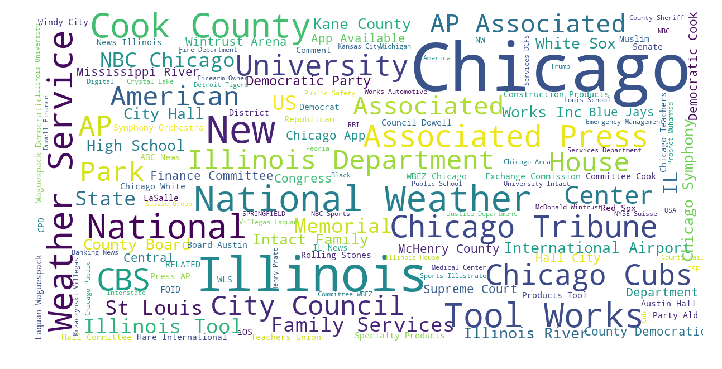

In [19]:
show_wordcloud(','.join(data[(data.sentiment == 'negative') & (~data.organization.isna())].organization.tolist()))

###### Showing people associated with negative sentiment

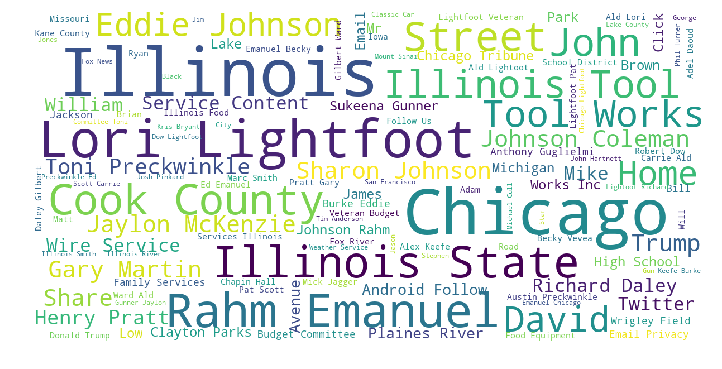

In [20]:
show_wordcloud(','.join(data[(data.sentiment == 'negative') & (~data.person.isna())].person.tolist()))

###### Showing locations associated with negative sentiment

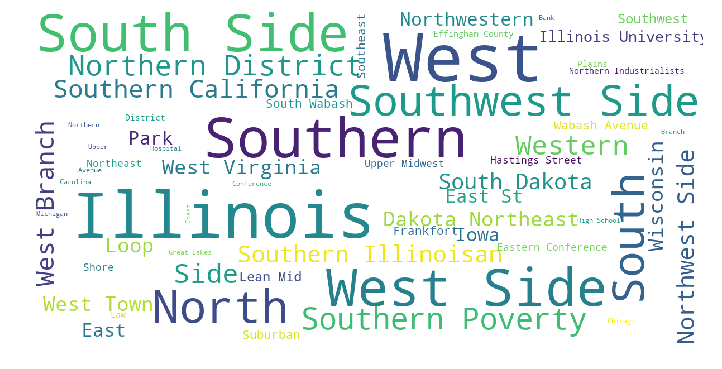

In [21]:
show_wordcloud(','.join(data[(data.sentiment == 'negative') & (~data.location.isna())].location.tolist()))

###### Showing GPE associated with negative sentiment

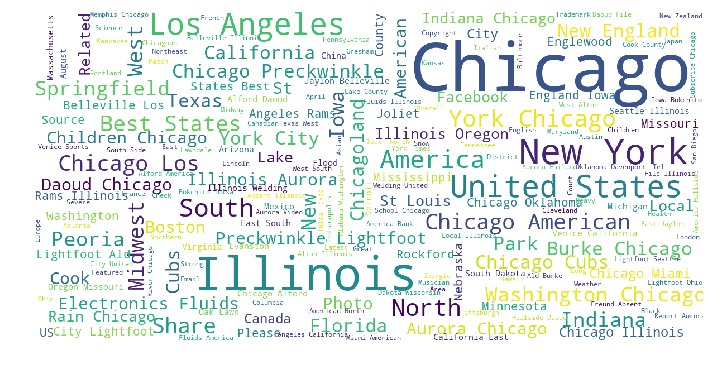

In [22]:
show_wordcloud(','.join(data[(data.sentiment == 'negative') & (~data.gpe.isna())].gpe.tolist()))

###### Showing facility associated with negative sentiment

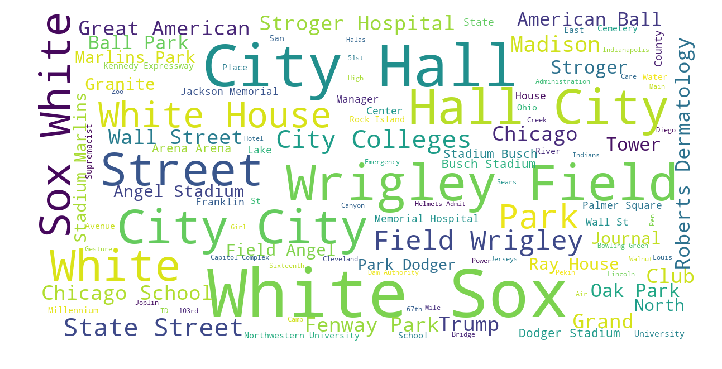

In [23]:
show_wordcloud(','.join(data[(data.sentiment == 'negative') & (~data.facility.isna())].facility.tolist()))

###### Showing organizations associated with positive sentiment

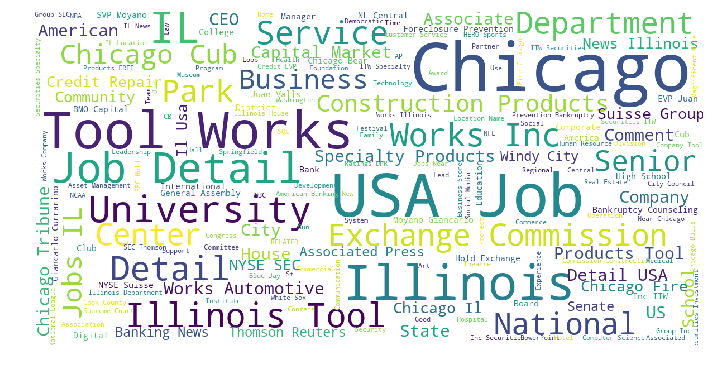

In [25]:
show_wordcloud(','.join(data[(data.sentiment == 'positive') & (~data.organization.isna())].organization.tolist()))

###### Showing person associated with positive sentiment

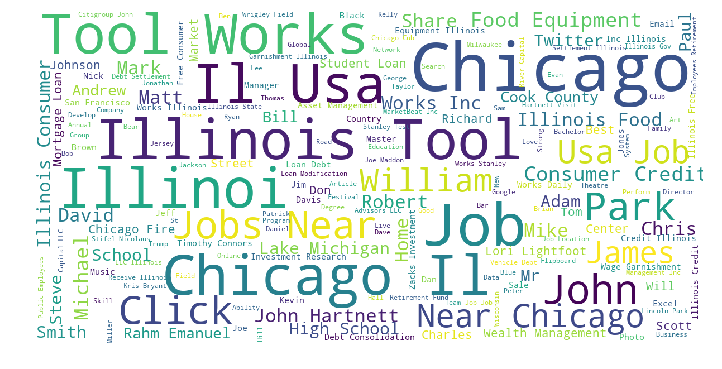

In [26]:
show_wordcloud(','.join(data[(data.sentiment == 'positive') & (~data.person.isna())].person.tolist()))

###### Showing location associated with positive sentiment

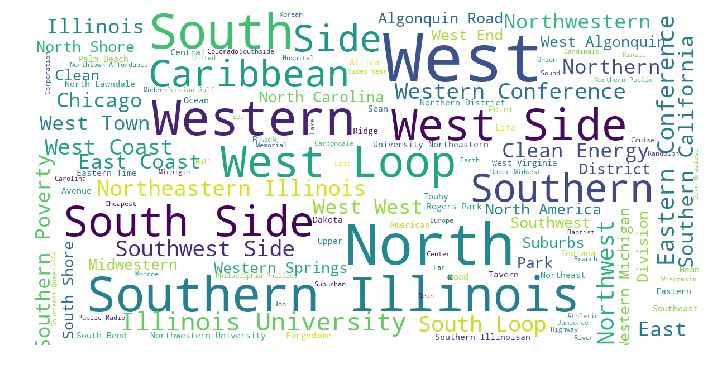

In [27]:
show_wordcloud(','.join(data[(data.sentiment == 'positive') & (~data.location.isna())].location.tolist()))

###### Showing gpe associated with positive sentiment

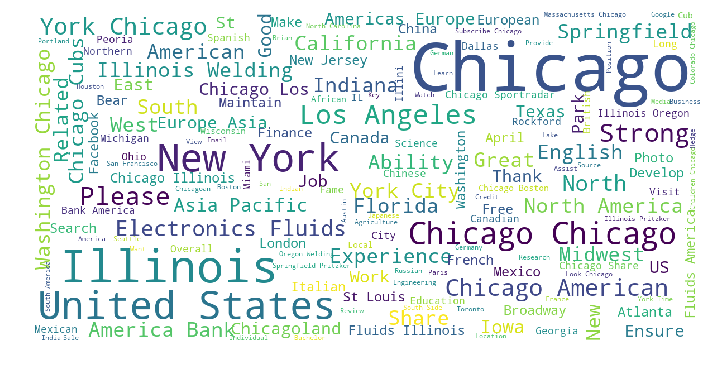

In [28]:
show_wordcloud(','.join(data[(data.sentiment == 'positive') & (~data.gpe.isna())].gpe.tolist()))

###### Showing facility associated with positive sentiment

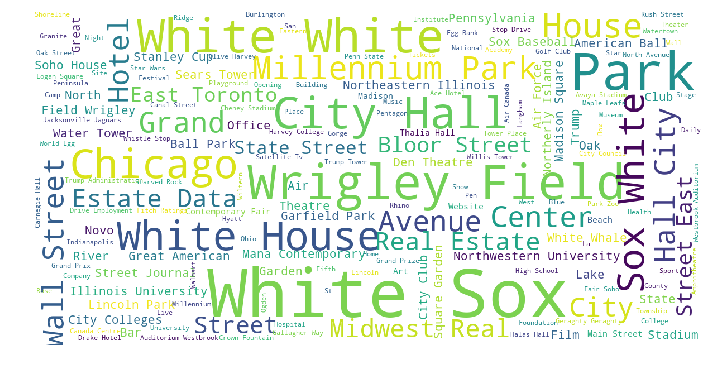

In [29]:
show_wordcloud(','.join(data[(data.sentiment == 'positive') & (~data.facility.isna())].facility.tolist()))

###### Sentiment for each topic

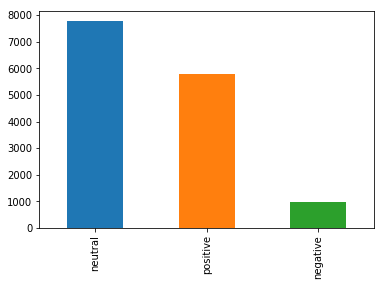

In [31]:
pd.value_counts(data[data.topic_number == 0].sentiment).plot.bar()

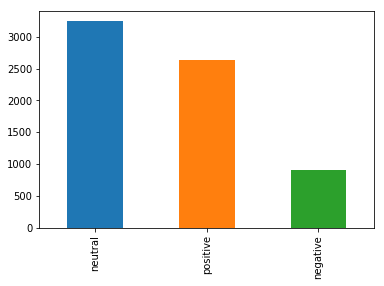

In [32]:
pd.value_counts(data[data.topic_number == 1].sentiment).plot.bar()

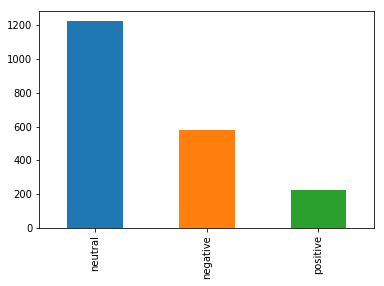

In [33]:
pd.value_counts(data[data.topic_number == 2].sentiment).plot.bar()

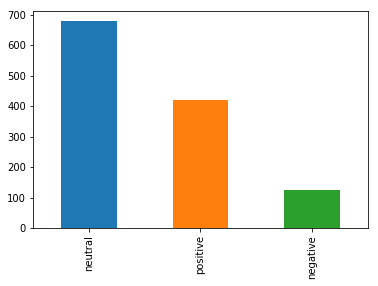

In [34]:
pd.value_counts(data[data.topic_number == 3].sentiment).plot.bar()

Based on the above word clouds, we can conclude the following
 - People are not happy with the government
 - People have a negative sentiment about all recent mayors of Chicago 
 - People have negative sentiment about incoming mayor Lori Lightfoot
 - People have negative sentiment about South and West Chicago
 - People have negative sentiment about City Hall

The government should do the following to attract people to move in
 - Advertise about Universities
 - Advertise the job market in the Chicago area
 - Advertise the tourist locations in the area
 - Improve the City Colleges of Chicago